### Autoencoders

An autoencoder uses a neural network to transform an input into a low-dimensional representation of the input, just like we've been doing with node embedding. The key insight is that the network tries to reconstruct its input from the low-dimensional embedding, as illustrated in the following figure.

<img src="figures/autoencoder.png" alt="eneral autoencoder architecture" width = "600">

Because I was trained as an engineer, I think of this as simple data compression. A good compression algorithm does two things:
 - it represents the original object using fewer "bits" than in the original object
 - it can be used to reconstruct the original object, hopefully with little loss of accuracy

 The process of turning the original object into the compressed representation is called __encoding__. The process of turning the compressed representation into an approximation of the original object is called __decoding__. 

The compressed representation is often called a _latent representation_. One meaning of the word "latent" is "hidden or dormant". The idea is that the compressed representation captures the fundamental structures hidden in the original object while getting rid of the parts of the original object that aren't necessary. It's like saying we've found the small representation hidden by the large representation of the original object.

---


### Graph Autoencoder

A graph autoencoder is a special application of a GCN. In the graph machine learning context, the output of a graph autoencoder is often called a _node embedding_ instead of the _latent representation_. I hope that the reason is fairly obvious: we are using the GCN to find a low-dimensional embedding of the original network structure. 

This part of the tutorial relies heavily on the [presentation from Antonio Longa](https://antoniolonga.github.io/Pytorch_geometric_tutorials/posts/post6.html), and the [Jupyter notebook used in the presentation](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial6/Tutorial6.ipynb). 


__Getting a graph into the pytorch data structure__

These examples will implement the GCN using pytorch. 
We'll demonstrate the steps using the pinwheel graph, first without features and then with features.

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/145869867.py:10: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


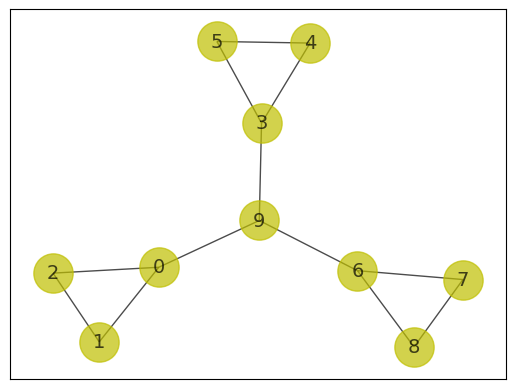

In [595]:
#############
## CELL 1  ##
#############
import networkx as nx

pinwheel_graph = nx.Graph()
pinwheel_graph.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
pinwheel_graph.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(6,7),(6,8),(7,8),(0,9),(3,9),(6,9)])
nx.draw_networkx(pinwheel_graph, 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color='y',
                 node_size=800,
                 font_size=14,
                 alpha = 0.7)

We'll be using a graph convolutional neural network to construct our graph autoencoder. Since GCNs need to remember each node's feature when they are blended with their neighbors' features, we need to add self loops.

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/2578830523.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


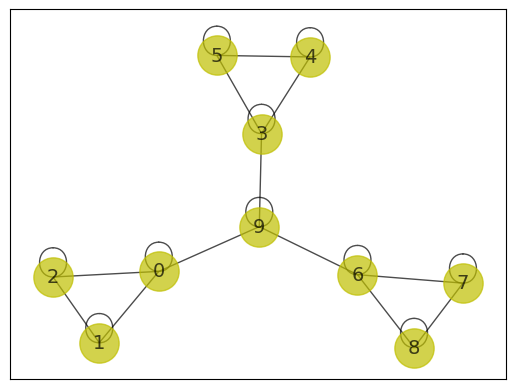

In [596]:
pinwheel_graph.add_edges_from([(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9)])
nx.draw_networkx(pinwheel_graph, 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color='y',
                 node_size=800,
                 font_size=14,
                 alpha = 0.7)

Pytorch has a utility that converts a networkx graph into the pytorch _data_ type.

In [597]:
#############
## CELL 2  ##
#############
import numpy as np
from torch_geometric.utils import from_networkx
from torch import Tensor
data = from_networkx(pinwheel_graph)      # convert to pytorch data structure
print(f"Pinwheel graph as pytorch data structure is\n\t {data}")

Pinwheel graph as pytorch data structure is
	 Data(edge_index=[2, 34], num_nodes=10)


Each data object has an edge_index member, which we access using the standard way of referencing object members.

```
    data.edge_index
```

The edge_index represents _graph connectivity_. This is essentially the edge set of the graph. The first index contains the ordered edge pair. The second index is the number of edges. Each edge is directed, which means that an undirected graph with an edge $\{u,v\}$ appears wtice in the edge_index: once as $(u,v)$ and again as $(v,u)$.


Let's look at the edge index data.

In [598]:
#############
## CELL 3  ##
#############
for i in {0,1,2,3}:
    print(f"edge is {data.edge_index[:,i]}")

edge is tensor([0, 1])
edge is tensor([0, 2])
edge is tensor([0, 9])
edge is tensor([0, 0])


Edges are represented as tensors, which for the purposes of CS 575 can be thought of simply as vectors.


We'll need inputs to the graph autoencoder, which we'll represent using _one-hot encoding_.

In [599]:
#############
## CELL 4  ##
#############
data.x = Tensor(np.eye(len(pinwheel_graph)))  # labels features using one-hop encoding
for node in [0,1,2,3,9]:
    print(f'x values node {node}: \n\t{data.x[node]}')
data.num_node_features = len(data.x)

x values node 0: 
	tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
x values node 1: 
	tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
x values node 2: 
	tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
x values node 3: 
	tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
x values node 9: 
	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


This encoding simply says that the feature of each node is a row vector that is zero everywhere except in the column corresponding to the node number.

In [600]:
print(data.num_node_features)

10


__Defining the Encoder__

The graph autoencoder that we'll implement is based on equations (3) and (4) from

```
    Pan, S., Hu, R., Long, G., Jiang, J., Yao, L., & Zhang, C. (2018). Adversarially regularized graph autoencoder for graph embedding. arXiv preprint arXiv:1802.04407.
```

The encoder consists of two GCN layers and one decoder layer. 

<img src="figures/graph_autoencoder.png" alt="Graph autoencoder example" width = "500">

The encoder has two hidden layers. For the first layer, $h1$ is computed using the matrix multiplications defined above 

$$ H^{(1)} = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X W$$

and then passing through a rectified linear unit

$$ f_{\rm ReLu}\left(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X W \right) $$

The rectified linear unit sets everything less than zero to zero and anything else to its original value,

$$ f_{\rm ReLu}(x) = \left\{ \begin{array}{rl} 0 & {\rm if\ } x < 0 \\ x & {\rm otherwise}\end{array}\right. $$

The second layer computes the embedding. Recall that a node embedding was a mapping from the set of graph nodes to a $d$-dimensional real-valued vector
$$ f: V\rightarrow \mathbb{R}^d $$ 

Let ${\mathbf z}_i = f({\mathbf x}_i)$, where ${\mathbf x}_i$ is the one-hot encoding for node $i$. ${\mathbf z}$ is computed using

$$ Z = \tilde{D}^{-1/2} \tilde{H^{(1)}} \tilde{D}^{-1/2} X W$$

We don't "squash" the output of the second hidden layer because we want the vector output from that layer.


__Implementation__

We'll implement this using pytorch geometric. 
The pytorch pipeline for training a neural network has the following stages:
 - _forward_: Run a forward pass of the network, which takes an input and generates the output.
 - _loss_: Compute an error, which is some form of difference between what the network generated and what we wanted to compute. 
 - _backward_: Propagate the loss back through the network to update the weights.
 - _optimize_: Let whatever (stochastic gradient descent) optimizer being used know to take a step in the direction of the gradient

Since we are implementing a graph autoencoder, we need to define an encoder and a decoder, both of which will be classes that the pytorch pipeline will use. 


__Encoder__

Let's begin by defining the encoder. This class must have define initializer and what happens on the forward step in the pipeline. The initializer function defines the network structure, which inherits from the torch.nn.Module parent class. The basic building block is the GCNConv class, which implements the matrix multiplications 

$$ \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X W$$

The forward function says how to use the convolution blocks. Each convolution function has two inputs:
 - the output from the previous layer, which is the feature vector $x$ for the first hidden layer.
 - the adjacency matrix, which is specified as the edge_index

 Let's start with a model that works. We can then do some variations on this model to see when it breaks.

In [601]:
#############
## CELL 5  ##
#############
from torch_geometric.nn import GAE
import torch
from torch_geometric.nn import GCNConv
class Encoder_With_Three_Layers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder_With_Three_Layers, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, 8 * out_channels)
        self.hidden_layer_2 = GCNConv(8 * out_channels, 2 * out_channels)
        self.hidden_layer_3 = GCNConv(2 * out_channels, out_channels)
        
    def forward(self, x, edge_index):
        h1 = self.hidden_layer_1(x, edge_index)
        h2 = self.hidden_layer_2(h1, edge_index)
        z = self.hidden_layer_3(h2, edge_index)
        return z

__Decoder__

Recall that the goal is to take node $i$, call it $u_i$, and compute a real-valued vector representation of the node, call it ${\mathbf z}_i$. We want the embedding to satisfy the property that two similar nodes end up close to each other in the embedding space.

- if ${\rm sim}(u_i, u_j)$ is high then ${\mathbf z}_i$ is near ${\mathbf z}_j$.

For a graph convolutional autoencoder, we need to define what we mean both by _similar_ and by _near_. 

- We'll use adjacency to define _similar_, so two nodes are similar if $A_{ij}=1$.
- We'll use cosine similarity as the metric for _near_, so we want ${\mathbf z}_i^T{\mathbf z}_j$ to be high.

The maximum value of the cosine between two vectors is 1, and the minimum value for the cosine between two vectors is -1. And since we aren't dividing by the length of ${\mathbf z}_i$ and ${\mathbf z}_j$ like we technicall have to do if we want the vector product to represent actual cosine, we aren't guaranteed that ${\mathbf z}_i^T{\mathbf z}_j$ will even be between $-1$ and $1$. To fix this, we'll pass this product through the sigmoid function, which means that _near_ is defined as

$$ \sigma({\mathbf z}_i^T{\mathbf z}_j) = \frac{1}{1+e^{-{\mathbf z}_i^T{\mathbf z}_j}}$$

which squashes the values of _near_ so that theya re always between $0$ and $1$. In other words, we'll approximate $A_{ij}$ by $\sigma({\mathbf z}_i^T{\mathbf z}_j)$.  The decoder does this computation for us.

To help illustrate the pieces, I've copied a portion of Figure 1 from

```
    Pan, S., Hu, R., Long, G., Jiang, J., Yao, L., & Zhang, C. (2018). Adversarially regularized graph autoencoder for graph embedding. arXiv preprint arXiv:1802.04407.
```

![Graph autoencoder architecture](figures/GAE_Architecture.png)

 Let's instantiate the graph autoencoder class in a way creates a 2D embedding. We pass the GAE class our encoder. We don't need to pass it the decoder (though we can if we want to) because it defaults to the decoder described in the previous paragraphs.

In [602]:
#############
## CELL 6  ##
#############
# parameters
out_channels = 4
num_features = data.num_features
# model
model = GAE(Encoder_With_Three_Layers(num_features, out_channels))

Let's inspect the pieces of our graph autoencoder.

In [603]:
print(model)

GAE(
  (encoder): Encoder_With_Three_Layers(
    (hidden_layer_1): GCNConv(10, 32)
    (hidden_layer_2): GCNConv(32, 8)
    (hidden_layer_3): GCNConv(8, 4)
  )
  (decoder): InnerProductDecoder()
)


The class "InnerProductDecoder" tells us that the decoder is built on the inner product operator, ${\mathbf z}^T{\mathbf z}$ "pushed through" the softmax operator.

__Finishing the pipeline__

The next thing we have to do is to set up the learning for pytorch. We'll need to specify a method that will compute the gradient for us, and we'll just use a state-of-the-art optimizer without talking about how it works.

In [604]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

We also have to set up a criterion used to compute the loss. Since a graph autoencoder tries to reconstruct its input, we'll use the default GAE function to do this. Note that I don't actually ever use the "criterion" function defined in the next cell since I'll directly call "model.recon_loss" in the training method, but I'm showing this next cell to emphasize what the loss function is.

In [605]:
criterion = model.recon_loss

Graph autoencoders can miss important parts of the graph structure if trained using only edges that appear in the network. We sometimes need to tell the loss function about edges that do not appear. The following function returns a set of edges that are not in the graph. We won't use it on our most simple model, but we'll see how it affects things later on in this tutorial.

In [606]:
def generate_negative_samples(graph_data, num_negative_samples):
    # Code from ChatGPT from prompt "how do i generate negative edge samples in pytorch"
    negative_samples = set()
    nodes = set(node for edge in graph_data for node in edge)
    
    while len(negative_samples) < num_negative_samples:
        # Randomly sample two nodes
        node1, node2 = torch.randint(0, len(nodes), (2,))
        if (node1.item(), node2.item()) not in graph_data and (node2.item(), node1.item()) not in graph_data:
            negative_samples.add((node1.item(), node2.item()))
    row = torch.Tensor([node[0] for node in negative_samples])
    row = row.int()
    col = torch.Tensor([node[1] for node in negative_samples])
    col = col.int()
    
    return torch.stack([row,col], dim=0)

Let's call this function on the pinwheel graph to build some intuition. It will return two tensors. The elements of the first tensor are one end of an edge, and the elements of the second tensor are the other.

In [607]:
num_neg_samples = 5
negative_samples = generate_negative_samples(pinwheel_graph.edges,num_neg_samples)
negative_samples = torch.Tensor.tolist(negative_samples)
for i in range(num_neg_samples):
    print(f"Edge {i} not in graph is {negative_samples[0][i],negative_samples[1][i]}")

Edge 0 not in graph is (1, 5)
Edge 1 not in graph is (6, 4)
Edge 2 not in graph is (0, 6)
Edge 3 not in graph is (9, 5)
Edge 4 not in graph is (8, 3)


You can confirm that none of these edges are in the pinwheel graph.

We now create a training function that sets up the learning pipeline. The training function has a lot of possible variations, but we'll just use the bare minimum: encode (which calls the forward function from the encoder), compute loss, propagate the loss backward, and tell the optimizer to update weights. We'll include a default setting that doesn't use negative samples.

In [608]:
#############
## CELL 7  ##
#############
def train(data, model, use_negative_samples = False):
    optimizer.zero_grad()  # Clear gradients.
    z = model.encode(data.x, data.edge_index)  # Perform a single forward pass.
    if use_negative_samples:
        negative_samples = generate_negative_samples(pinwheel_graph.edges,20)
        loss = model.recon_loss(z, data.edge_index, negative_samples) # Compute loss
    else:
        loss = model.recon_loss(z, data.edge_index)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, z

Now, we'll be a little sloppy. Rather than training the neural network on a subset of our data and then testing it on a different subset, repeating until the testing shows that we've learned well, we'll just run a bunch of training steps.

In [609]:
#############
## CELL 8  ##
#############
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model)
    ## Uncomment if you'd like to see how the embedding changes over time.
    #z = z.detach().numpy()
    #plt.scatter(z[:, 0], z[:, 1], s=70)

__Did it work?__

Let's see how well it did reconstructing the adjacency matrix. We'll define a function that reconstructs an approximation of the adjacency matrix from the encoding.

In [610]:
#############
## CELL 9  ##
#############
from scipy.special import expit # Sigmoid function that can operate on numpy objects
def get_A_hat(model):
    model.eval()
    Z = model.encode(data.x, data.edge_index)
    Z = Z.detach().numpy()
    A_hat = Z@np.transpose(Z)
    A_hat = expit(A_hat)
    return A_hat
print(np.round(get_A_hat(model),1))

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]


Compare to adjacency matrix

In [611]:
#############
## CELL 10 ##
#############
print(nx.linalg.adjacency_matrix(pinwheel_graph).toarray())

[[1 1 1 0 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 1]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 0]
 [1 0 0 1 0 0 1 0 0 1]]


The two matrices are identical. This means that with just two hidden layers we were able to find an encoding of the network that was "lossless", meaning that we were able to perfectly reconstruct the adjacency matrix using the encoding.

We can use the encoding to cluster similar nodes. Let's see how well this works, and then we'll break the model.

__See how well the embedding clustered__

We're using more than two dimensions for the embedding, so we'll use TSNE to compress this to two dimensions before visualizing.

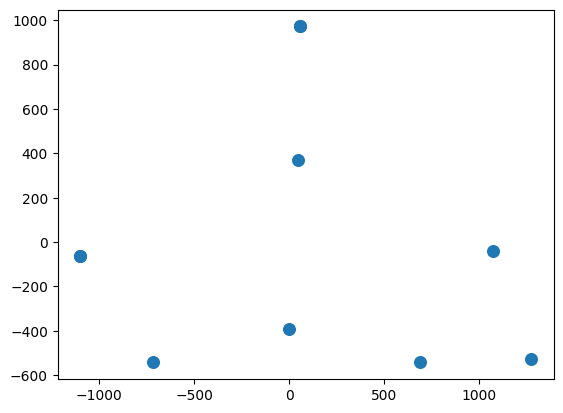

In [612]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(Z):
    z = TSNE(n_components=2, perplexity = 5).fit_transform(Z)
    plt.scatter(z[:, 0], z[:, 1], s=70)

Z = model.encode(data.x, data.edge_index).detach().numpy()
visualize(Z)


This shows a pretty good visual separation between node embeddings. Let's cluster on the original encoding to see which nodes belong together.

Cluster and show nodes by cluster color. Try 7 clusters first.

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/2564981279.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


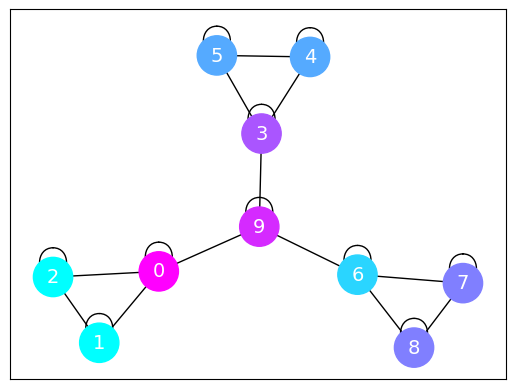

In [613]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=7,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
nx.draw_networkx(pinwheel_graph, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

Now try with four clusters

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/755915981.py:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


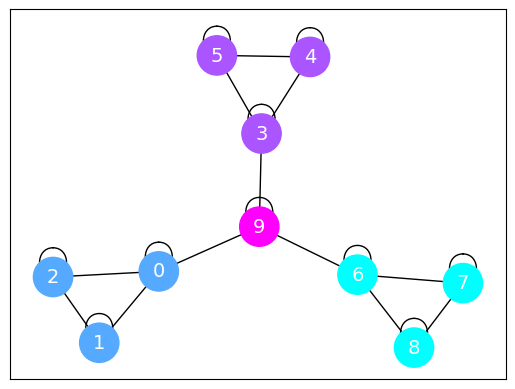

In [614]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
nx.draw_networkx(pinwheel_graph, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

The encoding produced by graph autoencoder did a good job of keeping structurally similar nodes together for both 7 clusters and 4 clusters. That's encouraging. 

---

Let's now change our model and see where it breaks. 

__Repeat but with only one hidden layer__

Let's see what happens when we reconstruct $\hat{A}$ and what happens when we try to partition the network.

In [615]:
class Encoder_With_One_Layer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder_With_One_Layer, self).__init__()
        self.hidden_layer = GCNConv(in_channels, out_channels)
    def forward(self, x, edge_index):
        z = self.hidden_layer(x, edge_index)
        return z
out_channels = 4
num_features = data.num_features
# Delete previous model and instantiate a new one
if 'model' in globals(): del model
model = GAE(Encoder_With_One_Layer(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


GAE(
  (encoder): Encoder_With_One_Layer(
    (hidden_layer): GCNConv(10, 4)
  )
  (decoder): InnerProductDecoder()
)


Nothing else needs to change. Let's train the model and inspect $\hat{A}$.

In [616]:
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model)
print(np.round(get_A_hat(model),1))

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]


$\hat{A}$ is has no structure.  This means that we weren't able to reconstruct the network from the encoding.

Before discussing why, let's try to improve the training by including negative samples. Reinstantiate the model and then train using negative samples.


In [617]:
del model
model = GAE(Encoder_With_One_Layer(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model, use_negative_samples=True)
print(np.round(get_A_hat(model),1))

GAE(
  (encoder): Encoder_With_One_Layer(
    (hidden_layer): GCNConv(10, 4)
  )
  (decoder): InnerProductDecoder()
)
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]


You might be able to argue that we are starting to see some structure emerge ... try rounding to the nearest integer and comparing to the actual adjacency matrix for the pinwheel graph. Negative sampling helps because it says "don't let the encoding turn non-edges from the pinwheel network into edges in the reconstruction". 

But you'd have to train on all edges and negative sampled edges to get this encoding to work OK. The problem is that we don't have enough information in just one convolution layer to reconstruct the network. At least two convolution layers are needed.

__Try Two Hidden Layers__

In [618]:
class Encoder_With_Two_Layers(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder_With_Two_Layers, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, 4 * out_channels)
        self.hidden_layer_2 = GCNConv(4 * out_channels, out_channels)
        
    def forward(self, x, edge_index):
        h1 = self.hidden_layer_1(x, edge_index)
        z = self.hidden_layer_2(h1, edge_index)
        return z
if 'model' in globals(): del model
model = GAE(Encoder_With_Two_Layers(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model, use_negative_samples=True)
print(np.round(get_A_hat(model),2))

GAE(
  (encoder): Encoder_With_Two_Layers(
    (hidden_layer_1): GCNConv(10, 16)
    (hidden_layer_2): GCNConv(16, 4)
  )
  (decoder): InnerProductDecoder()
)
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]


__Changing the Dimension of the Embedding__

Let's see what happens when we have one layer but try to make the embedding smaller. 

In [619]:
out_channels = 2
num_features = data.num_features
if 'model' in globals(): del model
model = GAE(Encoder_With_One_Layer(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model, use_negative_samples=True)
print(np.round(get_A_hat(model),1))

GAE(
  (encoder): Encoder_With_One_Layer(
    (hidden_layer): GCNConv(10, 2)
  )
  (decoder): InnerProductDecoder()
)
GAE(
  (encoder): Encoder_With_One_Layer(
    (hidden_layer): GCNConv(10, 2)
  )
  (decoder): InnerProductDecoder()
)
[[1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.4]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.4]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.5]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.5]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.5]
 [0.6 0.6 0.6 0.4 0.4 0.4 0.5 0.5 0.5 0.5]]


We lose information around the middle node of the pinwheel network. What if we have three dimensions?


In [620]:
out_channels = 3
num_features = data.num_features
if 'model' in globals(): del model
model = GAE(Encoder_With_One_Layer(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model)#, use_negative_samples=True)
print(np.round(get_A_hat(model),1))

GAE(
  (encoder): Encoder_With_One_Layer(
    (hidden_layer): GCNConv(10, 3)
  )
  (decoder): InnerProductDecoder()
)
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]



What about with three hidden layers

In [621]:
out_channels = 2
num_features = data.num_features
if 'model' in globals(): del model
model = GAE(Encoder_With_Three_Layers(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train(data, model)#, use_negative_samples=True)
print(np.round(get_A_hat(model),1))

GAE(
  (encoder): Encoder_With_Three_Layers(
    (hidden_layer_1): GCNConv(10, 16)
    (hidden_layer_2): GCNConv(16, 4)
    (hidden_layer_3): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)
[[1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [1.  1.  1.  0.  0.  0.  0.  0.  0.  0.6]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.5]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.5]
 [0.  0.  0.  1.  1.  1.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.4]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.4]
 [0.  0.  0.  0.  0.  0.  1.  1.  1.  0.4]
 [0.6 0.6 0.6 0.5 0.5 0.5 0.4 0.4 0.4 0.5]]


__Repeat but with node features__

In [622]:
pinwheel_graph = nx.Graph()
for i in range(0,10):  # give each node a feature. We'll set them in a minute.
    if i in {1,2,4,5,7,8}: pinwheel_graph.add_node(i, feature = [i+1,0.0,0.0])
    elif i in {0,3,6}: pinwheel_graph.add_node(i, feature = [0.0,i+1,0.0])
    else: pinwheel_graph.add_node(i, feature = [0.0,0.0,i+1])
pinwheel_graph.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(6,7),(6,8),(7,8),(0,9),(3,9),(6,9)])
pinwheel_graph.add_edges_from([(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9)])
data = from_networkx(pinwheel_graph)      # convert to pytorch data structure
print(f"Pinwheel graph as pytorch data structure is\n\t {data}")
print(data.feature)

Pinwheel graph as pytorch data structure is
	 Data(edge_index=[2, 34], feature=[10, 3], num_nodes=10)
tensor([[ 0.,  1.,  0.],
        [ 2.,  0.,  0.],
        [ 3.,  0.,  0.],
        [ 0.,  4.,  0.],
        [ 5.,  0.,  0.],
        [ 6.,  0.,  0.],
        [ 0.,  7.,  0.],
        [ 8.,  0.,  0.],
        [ 9.,  0.,  0.],
        [ 0.,  0., 10.]])


In [623]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, 4 * out_channels)
        self.hidden_layer_2 = GCNConv(4 * out_channels, 2 * out_channels)        
        self.embedding = GCNConv(2 * out_channels, out_channels)
    def forward(self, x, edge_index):
        h1 = self.hidden_layer_1(x, edge_index)
        h2 = self.hidden_layer_2(h1, edge_index)
        z = self.embedding(h2, edge_index)
        return z
# parameters
out_channels = 3
num_features = torch.Tensor.size(data.feature)[1]
print(f"There are {num_features} features")
if 'model' in globals(): del model
model = GAE(Encoder(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


There are 3 features
GAE(
  (encoder): Encoder(
    (hidden_layer_1): GCNConv(3, 12)
    (hidden_layer_2): GCNConv(12, 6)
    (embedding): GCNConv(6, 3)
  )
  (decoder): InnerProductDecoder()
)


In [624]:
def train_with_features(data, model):
    optimizer.zero_grad()  # Clear gradients.
    z = model.encode(data.feature, data.edge_index)  # Perform a single forward pass.
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, z

epochs = 1000
for epoch in range(1, epochs):
    loss, z = train_with_features(data, model)

inspect the embedding

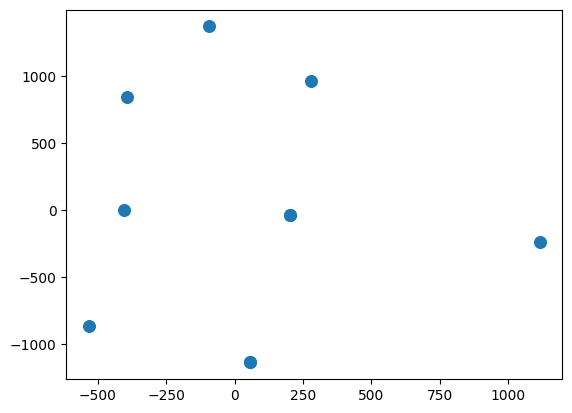

In [625]:
Z = model.encode(data.feature, data.edge_index).detach().numpy()
visualize(Z)

inspect the approximation to the adjacency matrix

In [626]:
from scipy.special import expit
A_hat = Z@np.transpose(Z)
A_hat = expit(A_hat)
print(np.round(A_hat,1))

[[1.  1.  1.  0.6 0.3 0.3 0.  0.  0.  0.9]
 [1.  1.  1.  0.3 0.5 0.5 0.  0.  0.  0.1]
 [1.  1.  1.  0.3 0.5 0.5 0.  0.  0.  0.1]
 [0.6 0.3 0.3 0.6 0.4 0.4 0.7 0.4 0.4 0.9]
 [0.3 0.5 0.5 0.4 0.6 0.6 0.5 0.8 0.8 0.1]
 [0.3 0.5 0.5 0.4 0.6 0.6 0.5 0.8 0.8 0.1]
 [0.  0.  0.  0.7 0.5 0.5 1.  1.  1.  0.9]
 [0.  0.  0.  0.4 0.8 0.8 1.  1.  1.  0.1]
 [0.  0.  0.  0.4 0.8 0.8 1.  1.  1.  0.1]
 [0.9 0.1 0.1 0.9 0.1 0.1 0.9 0.1 0.1 1. ]]


This matrix has a lot more going on, but the basic structure still pops out.

Cluster nodes and inspect. First, 7 clusters.

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/2564981279.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


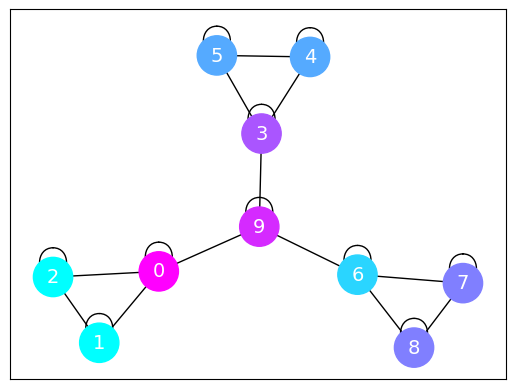

In [627]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=7,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
nx.draw_networkx(pinwheel_graph, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

And with fewer clusters

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/2538380487.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),


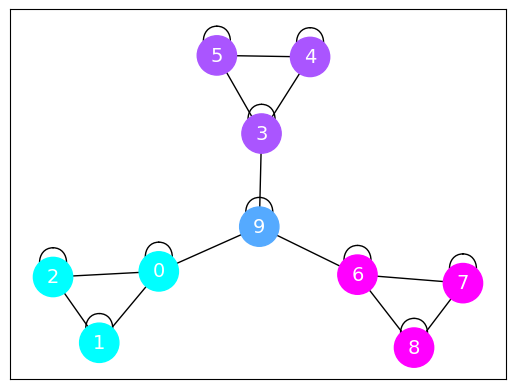

In [628]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
nx.draw_networkx(pinwheel_graph, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

This does well. What happens if we change to a single layer give the new feature set?

In [629]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, 4 * out_channels)
    def forward(self, x, edge_index):
        z = self.hidden_layer_1(x, edge_index)
        return z
# parameters
out_channels = 3
num_features = torch.Tensor.size(data.feature)[1]
print(f"There are {num_features} features")
if 'model' in globals(): del model
model = GAE(Encoder(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

There are 3 features
GAE(
  (encoder): Encoder(
    (hidden_layer_1): GCNConv(3, 12)
  )
  (decoder): InnerProductDecoder()
)


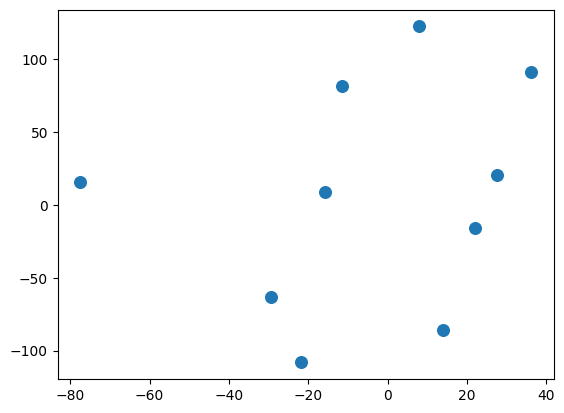

In [630]:
epochs = 1000
for epoch in range(1, epochs):
    loss, z = train_with_features(data, model)
from scipy.special import expit
Z = model.encode(data.feature, data.edge_index).detach().numpy()
visualize(Z)


In [631]:
A_hat = Z@np.transpose(Z)
A_hat = expit(A_hat)
print(np.round(A_hat,1))

[[1.  1.  1.  0.5 0.4 0.4 0.  0.  0.  1. ]
 [1.  1.  1.  0.4 0.5 0.5 0.  0.  0.  0. ]
 [1.  1.  1.  0.4 0.5 0.5 0.  0.  0.  0. ]
 [0.5 0.4 0.4 0.6 0.4 0.4 0.6 0.5 0.5 1. ]
 [0.4 0.5 0.5 0.4 0.5 0.5 0.5 0.6 0.6 0. ]
 [0.4 0.5 0.5 0.4 0.5 0.5 0.5 0.6 0.6 0. ]
 [0.  0.  0.  0.6 0.5 0.5 1.  1.  1.  1. ]
 [0.  0.  0.  0.5 0.6 0.6 1.  1.  1.  0. ]
 [0.  0.  0.  0.5 0.6 0.6 1.  1.  1.  0. ]
 [1.  0.  0.  1.  0.  0.  1.  0.  0.  1. ]]


---

### Graph Autoencoder for the Karate Graph

Let's see what kind of clustering we get on the karate club graph

In [632]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')

Dataset: KarateClub():
Number of graphs: 1


This dataset only has one graph, so let's use the data from that graph. We'll begin by inspecting the data object.

In [633]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


Each data object has x, edge_index, and y. Some have other information like the masks.  
- x contains _node features_. The first index is the number of nodes, and the second index is the number of features. The cora database which we'll explore later has 2708 nodes each with a feature vector with 1433 components. The karate graph has 34 nodes and 34 features, discussed in the next cell.
- y contains _node labels_. If our goal is to classify nodes then it helps to have some of the nodes labeled.
- edge_index has _graph connectivity_. This is essentially the edge set of the graph. The first index contains the ordered edge pair. The second index is the number of edges. Each edge is directed, which means that an undirected graph with an edge $\{u,v\}$ appears twice in the edge_index: once as $(u,v)$ and again as $(v,u)$.

We'll use the one-hot encoding found in the karate club data.

In [634]:
for node in [0,1,2,32,33]:
    print(f'Features 0-9 of node {node}: \t{data.x[node][0:10]}')
    #print(f'Features 10-19 of node {node}: \t{data.x[node][10:20]}')
    #print(f'Features 20-29 of node {node}: \t{data.x[node][20:30]}')
    print(f'Features 30-34 of node {node}: \t{data.x[node][30:34]}')
    print('-----------------------')

Features 0-9 of node 0: 	tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Features 30-34 of node 0: 	tensor([0., 0., 0., 0.])
-----------------------
Features 0-9 of node 1: 	tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Features 30-34 of node 1: 	tensor([0., 0., 0., 0.])
-----------------------
Features 0-9 of node 2: 	tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Features 30-34 of node 2: 	tensor([0., 0., 0., 0.])
-----------------------
Features 0-9 of node 32: 	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Features 30-34 of node 32: 	tensor([0., 0., 1., 0.])
-----------------------
Features 0-9 of node 33: 	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Features 30-34 of node 33: 	tensor([0., 0., 0., 1.])
-----------------------


Let's build a graph autoencoder for this graph. We'll ignore the class labels on the nodes. We'll use those in the next tutorial.

In [635]:
#############
## Cell 11 ##
#############

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, 8 * out_channels)
        self.hidden_layer_2 = GCNConv(8 * out_channels, 4 * out_channels)        
        self.embedding = GCNConv(4 * out_channels, out_channels)
    def forward(self, x, edge_index):
        h1 = self.hidden_layer_1(x, edge_index)
        h2 = self.hidden_layer_2(h1, edge_index)
        z = self.embedding(h2, edge_index)
        return z

In [636]:
# parameters
out_channels = 3
num_features = torch.Tensor.size(data.x)[1]
print(num_features)
if 'model' in globals(): del model
model = GAE(Encoder(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

34
GAE(
  (encoder): Encoder(
    (hidden_layer_1): GCNConv(34, 24)
    (hidden_layer_2): GCNConv(24, 12)
    (embedding): GCNConv(12, 3)
  )
  (decoder): InnerProductDecoder()
)


In [637]:
def train(data, model):
    optimizer.zero_grad()  # Clear gradients.
    z = model.encode(data.x, data.edge_index)  # Perform a single forward pass.
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return z

epochs = 1000
for epoch in range(1, epochs):
    z = train(data, model)

Inspect the embedding

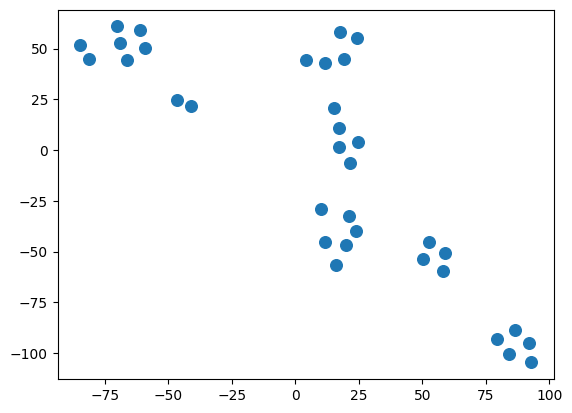

In [638]:
model.eval()
#with torch.no_grad():
Z = model.encode(data.x, data.edge_index).detach().numpy()
visualize(Z)

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3239920911.py:13: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


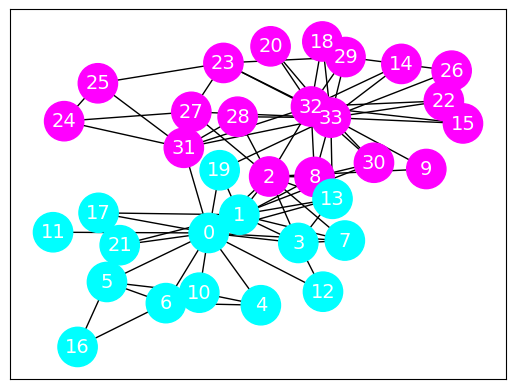

In [639]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

and if we look at more clusters?

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3356321355.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


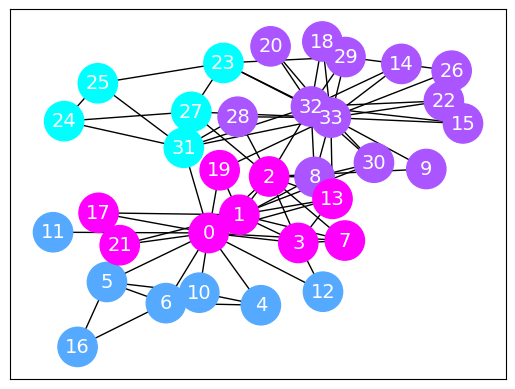

In [640]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

This is very similar to what we've seen before. What happens if we change to an embedding dimension of 2?

In [641]:
out_channels = 2
num_features = torch.Tensor.size(data.x)[1]
print(num_features)
if 'model' in globals(): del model
model = GAE(Encoder(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

34
GAE(
  (encoder): Encoder(
    (hidden_layer_1): GCNConv(34, 16)
    (hidden_layer_2): GCNConv(16, 8)
    (embedding): GCNConv(8, 2)
  )
  (decoder): InnerProductDecoder()
)


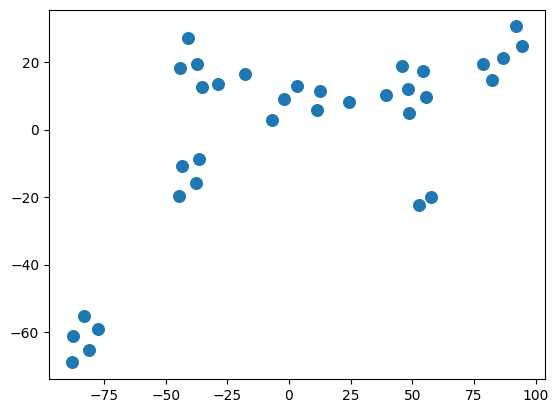

In [642]:
epochs = 1000
for epoch in range(1, epochs):
    z = train(data, model)
model.eval()
#with torch.no_grad():
Z = model.encode(data.x, data.edge_index).detach().numpy()
visualize(Z)

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3695264858.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


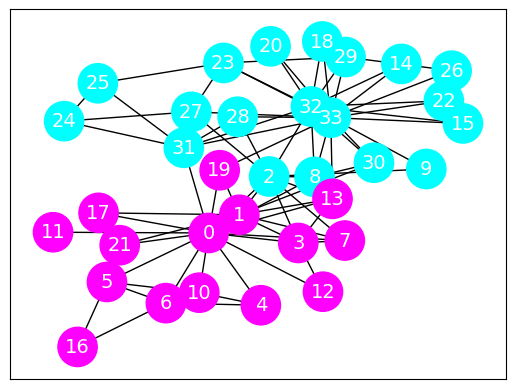

In [645]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3356321355.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


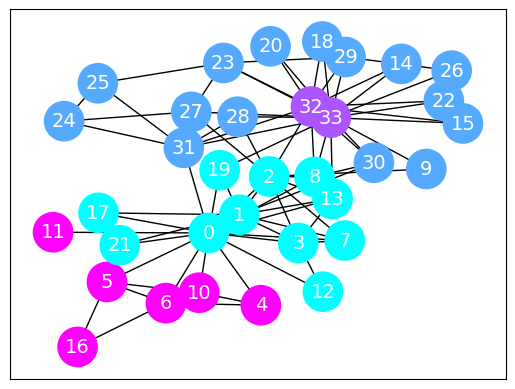

In [646]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

What happens with the bare bones autoencoder?

In [647]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = GCNConv(in_channels, out_channels)
    def forward(self, x, edge_index):
        z = self.hidden_layer_1(x, edge_index)
        return z
out_channels = 3
num_features = torch.Tensor.size(data.x)[1]
print(num_features)
if 'model' in globals(): del model
model = GAE(Encoder(num_features, out_channels))
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

34
GAE(
  (encoder): Encoder(
    (hidden_layer_1): GCNConv(34, 3)
  )
  (decoder): InnerProductDecoder()
)


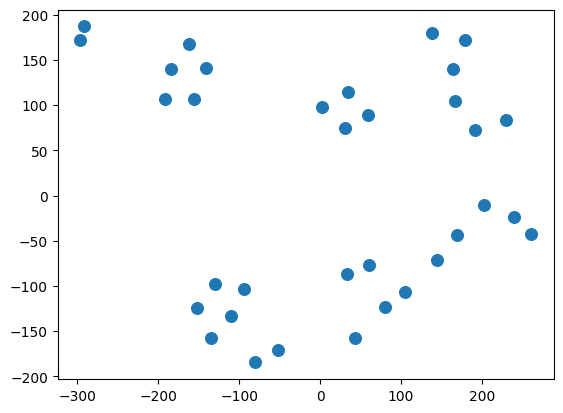

In [648]:
epochs = 1000
for epoch in range(1, epochs):
    z = train(data, model)
model.eval()
Z = model.encode(data.x, data.edge_index).detach().numpy()
visualize(Z)

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3695264858.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


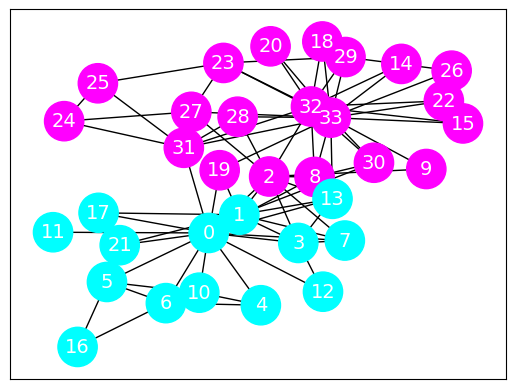

In [649]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_6641/3058077772.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),


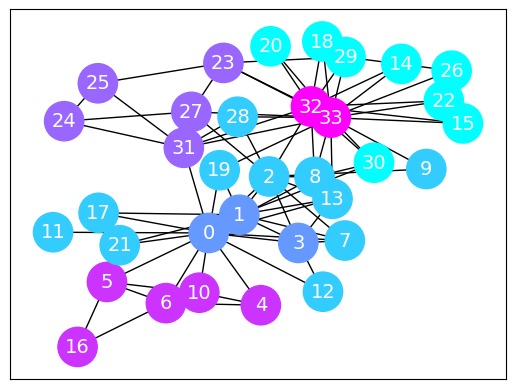

In [651]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=10,
    random_state=1234
    )
kmeans.fit(Z)
#print(kmeans.labels_)
G = nx.karate_club_graph()
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 font_size=14,
                 font_color='white')